# Twitter vs Stocks Change Data Analysis

## Data Cleaning Notebook

In [398]:
# Packages:
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from urllib.request import urlopen
import json
import datetime
import numpy as np
import warnings
from textblob import TextBlob
import re

### Tweets DF, Sentimental Analysis and Tweets Cleaning Functions

In [399]:
# Function to clean Tweet Texts:
def cleantext(text):
    text = re.sub(r"@[A-Za-z0-9]+", "", text) # Remove Mentions
    text = re.sub(r"#", "", text) # Remove Hashtags Symbol
    text = re.sub(r"RT[\s]+", "", text) # Remove Retweets
    text = re.sub(r"https?:\/\/\S+", "", text) # Remove The Hyper Link
    
    return text

In [400]:
def Tweet_Clean(csv):

    # Pulling CSV with Twitter information. Check ceo_name.ipynb for data extraction:
    ceo_tweets = pd.read_csv(csv)
    columns_chosed = ['created_at','full_text','id','source','favorite_count','retweet_count']
    ceo_tweets = ceo_tweets[columns_chosed]

    # Filtering Dataframe for tweets since 2019:
    ceo_tweets["created_at"] = pd.to_datetime(ceo_tweets["created_at"]).dt.date
    ceo_tweets["created_at"] = pd.to_datetime(ceo_tweets["created_at"])
    ceo_tweets = ceo_tweets[ceo_tweets["created_at"]>='2019-01-01']

    # Clean The Text:
    ceo_tweets['full_text'] = ceo_tweets['full_text'].apply(cleantext)

    # Checking weekends:
    ceo_tweets["Day of Week"] = ceo_tweets['created_at'].dt.dayofweek
    ceo_tweets['orig_date'] = ceo_tweets['created_at']

    # Moving Tweets made during weekend to Monday:
    for i in range(ceo_tweets.shape[0]):
        if ceo_tweets['Day of Week'].loc[i] == 5:
            ceo_tweets['created_at'].loc[i] = ceo_tweets['created_at'].loc[i]+ datetime.timedelta(days=2)
        if ceo_tweets['Day of Week'].loc[i] == 6:
            ceo_tweets['created_at'].loc[i] = ceo_tweets['created_at'].loc[i]+ datetime.timedelta(days=1)

    # Get The Subjectivity
    def sentiment_analysis(ds):
        sentiment = TextBlob(ds['full_text']).sentiment
        return pd.Series([sentiment.subjectivity, sentiment.polarity])

    # Adding Subjectivity & Polarity
    ceo_tweets[["subjectivity", "polarity"]] = ceo_tweets.apply(sentiment_analysis, axis=1)

    # Aggregating Tweets by Date:
    ceo_tweets = (    
        ceo_tweets.groupby(["created_at"])
        .agg(
            Tweets=("full_text", "sum"),
            Agg_count=("full_text", "count"),
            Agg_retweet=("retweet_count", "sum"),
            Agg_favorite=("favorite_count", "sum"),
            Subjectivity_mean=("subjectivity", "mean"),
            Polarity_mean=("polarity", "mean"),
        )
        .reset_index()
    )
    ceo_tweets = ceo_tweets.rename(columns={"created_at":'Date'})

    #Calculating Polarity Change
    ceo_tweets["Polarity_chg"] = np.log(ceo_tweets["Polarity_mean"]/ceo_tweets["Polarity_mean"].shift())
    ceo_tweets["Polarity_chg"] = ceo_tweets["Polarity_chg"].fillna(0)

    return ceo_tweets

### Stock Data Cleaning Function

In [401]:
def Stock_Clean(stock):

    # Getting Data Stock prices. Source: Yahoo Finance.
    stock = pd.read_csv(stock)
    stock_df = stock[['Date','Close']]

    # Calculating Stock Price Variation
    stock_df['Return'] = stock_df['Close']
    stock_df['Return']= np.log(stock_df['Close']/stock_df['Close'].shift())

    stock_df["Date"] = pd.to_datetime(stock_df["Date"]).dt.date
    stock_df["Date"] = pd.to_datetime(stock_df["Date"])
    
    return stock_df

### Function to Merge Stocks and Tweets DFs:

In [402]:
def Merging_dfs(stock_df,ceo_tweets):

    df_stock_tweets = stock_df.merge(ceo_tweets, how='left', on='Date')

    colnan = ['Agg_count','Agg_retweet','Agg_favorite','Subjectivity_mean','Polarity_mean','Polarity_chg']
    for col in colnan:
        df_stock_tweets[col] = df_stock_tweets[col].fillna(0)

    df_stock_tweets['Tweets'] = df_stock_tweets['Tweets'].fillna('')
    
    return df_stock_tweets

## Applying the functions:

In [408]:
ceo_tweets = Tweet_Clean("data/raw/drewhouston.csv")
stock_df = Stock_Clean("data/raw/DBX.csv")
df_stock_tweets = Merging_dfs(stock_df,ceo_tweets)
df_stock_tweets.to_csv('data/processed/drewhouston_cleaned.csv', index=False)
df_stock_tweets

,Date,Close,Return,Tweets,Agg_count,Agg_retweet,Agg_favorite,Subjectivity_mean,Polarity_mean,Polarity_chg
0,2018-03-23,28.480000,NaN,,0.0,0.0,0.0,0.000000,0.000000,0.000000
1,2018-03-26,30.450001,0.066884,,0.0,0.0,0.0,0.000000,0.000000,0.000000
2,2018-03-27,29.900000,-0.018228,,0.0,0.0,0.0,0.000000,0.000000,0.000000
3,2018-03-28,30.980000,0.035483,,0.0,0.0,0.0,0.000000,0.000000,0.000000
4,2018-03-29,31.250000,0.008678,,0.0,0.0,0.0,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...
925,2021-11-23,24.520000,0.002041,Here’s what happened when I tried incredible ...,3.0,136.0,1013.0,0.661111,0.201389,0.479308
926,2021-11-24,24.530001,0.000408,This is the moment we told Keisha Schahaff she...,1.0,104.0,803.0,0.000000,0.000000,-inf
927,2021-11-26,24.340000,-0.007776,,0.0,0.0,0.0,0.000000,0.000000,0.000000
928,2021-11-29,24.950001,0.024753,Thank you for the wonderful tribute It’s that...,2.0,74.0,734.0,0.800000,0.769444,inf


## Preliminary Plots

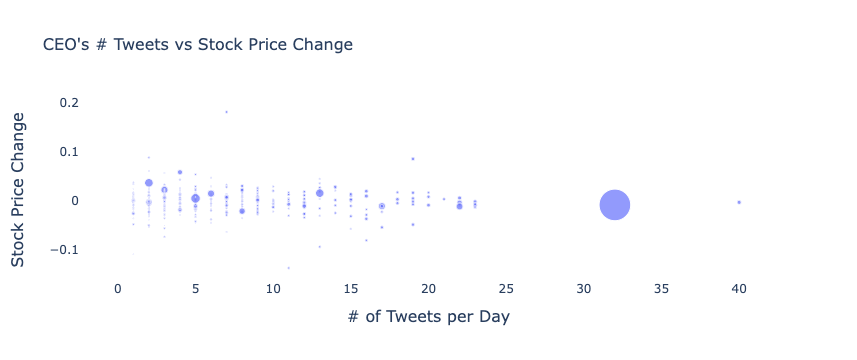

In [404]:
fig = go.Figure()
_ = fig.add_trace(go.Scatter(
    x= df_stock_tweets['Agg_count'],
    y= df_stock_tweets['Return'],
    mode="markers",
    marker={"size": df_stock_tweets['Agg_favorite'], "sizemode": "area",
                                    "sizeref": 2*max(df_stock_tweets['Agg_favorite']/1000)},
    hovertemplate= "Number of Tweets per Day: %{x:.1f}<br>" +
    "Stock Price Change: %{y:.1f}<br>" +
    "Number of Likes: %{marker.size:,}" +
    "<extra></extra>"
))
fig.update_layout(
    plot_bgcolor="white",
    yaxis={"title": {"text": "Stock Price Change", "font": {"size": 16}}},
    xaxis={"title": {"text": "# of Tweets per Day", "font": {"size": 16}}},
    # hovermode="x",
    title={'text': "CEO's # Tweets vs Stock Price Change", "font": {"size": 16}}
)
fig.show()

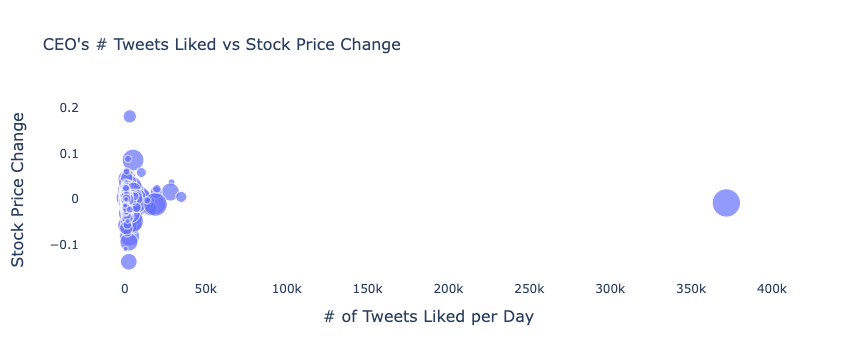

In [405]:
fig = go.Figure()
_ = fig.add_trace(go.Scatter(
    x= df_stock_tweets['Agg_favorite'],
    y= df_stock_tweets['Return'],
    mode="markers",
    marker={"size": df_stock_tweets['Agg_count'], "sizemode": "area",
                                    "sizeref": 2*max(df_stock_tweets['Agg_count']/1000)},
    hovertemplate= "Number of Tweets Liked per Day: %{x:.1f}<br>" +
    "Stock Price Change: %{y:.1f}<br>" +
    "Number of Tweets: %{marker.size:,}" +
    "<extra></extra>"
))
fig.update_layout(
    plot_bgcolor="white",
    yaxis={"title": {"text": "Stock Price Change", "font": {"size": 16}}},
    xaxis={"title": {"text": "# of Tweets Liked per Day", "font": {"size": 16}}},
    # hovermode="x",
    title={'text': "CEO's # Tweets Liked vs Stock Price Change", "font": {"size": 16}}
)
fig.show()

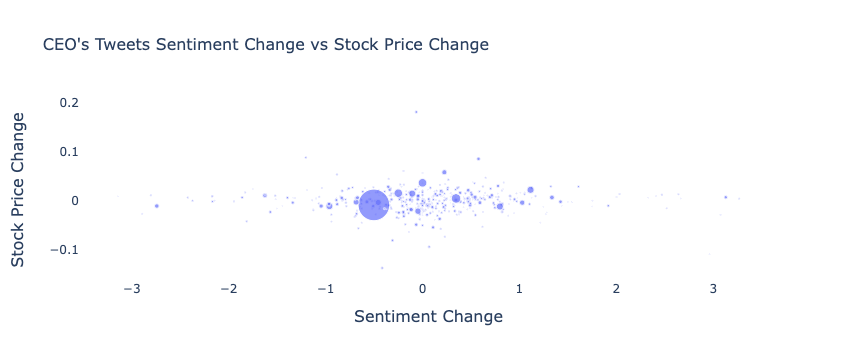

In [406]:
fig = go.Figure()
_ = fig.add_trace(go.Scatter(
    x= df_stock_tweets["Polarity_chg"],
    y= df_stock_tweets['Return'],
    mode="markers",
    marker={"size": df_stock_tweets['Agg_favorite'], "sizemode": "area",
                                    "sizeref": 2*max(df_stock_tweets['Agg_favorite']/1000)},
    hovertemplate= "Polarity of Tweets: %{x:.1f}<br>" +
    "Stock Price Change: %{y:.1f}<br>" +
    "Number of Likes: %{marker.size:,}" +
    "<extra></extra>"
))
fig.update_layout(
    plot_bgcolor="white",
    # hovermode="x",
    xaxis={"title": {"text": "Sentiment Change", "font": {"size": 16}}},
    yaxis={"title": {"text": "Stock Price Change", "font": {"size": 16}}},
    title={'text': "CEO's Tweets Sentiment Change vs Stock Price Change", "font": {"size": 16}}
)
fig.show()

## Word Clound

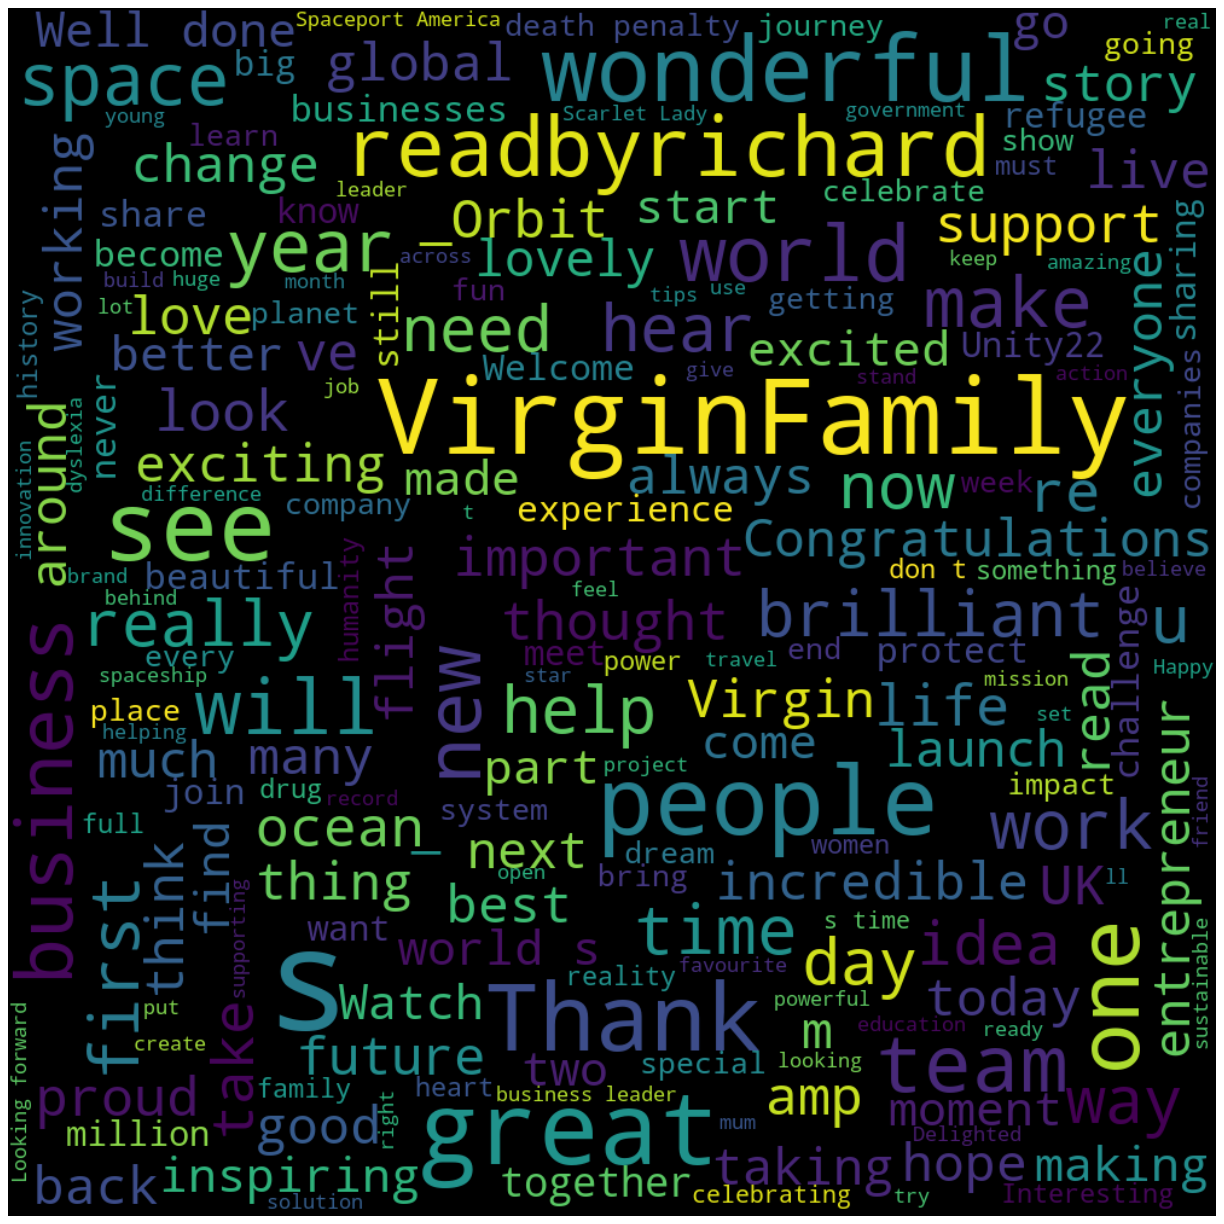

In [407]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
allwords = " ".join([twts for twts in df_stock_tweets['Tweets']])
wordCloud = WordCloud(width = 1000, height = 1000, random_state = 21, max_font_size = 119).generate(allwords)
plt.figure(figsize=(20, 20), dpi=80)
plt.imshow(wordCloud, interpolation = "bilinear")
plt.axis("off")
plt.show()